# Prepare experiment data for tensor SVD input in .mat format
Experiment data acquired on STO cleavage sample, data in unit of counts, resample to 183x183 frames with 160 total frames for Rungang to try his latest tensor denoising method.

In [2]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

In [6]:
datacube = np.zeros((183,183,160))
start_frame = 100 # avoid first few frames which suffers from slave mode shutter artifact
path = '/srv/home/chenyu/DEbackup/071519/S7/npy/'
for iframe in range(start_frame,start_frame+161-1):
    sample = np.load(path+'S7_'+format(iframe,'05')+'.npy') # load raw data in intensity counts
    sample = sample/224  # convert into electron counts
    resized = cv2.resize(sample, (183,183), interpolation = cv2.INTER_AREA)   # resize image into 183x183
    resized = resized / np.sum(resized) * np.sum(sample)
    datacube[:,:,iframe-start_frame] = resized.astype(int)

In [10]:
# save as Matlab .mat file
# Create a dictionary
adict = {}
adict['datacube'] = datacube
sio.savemat('/srv/home/chenyu/DEbackup/071519/S7/datacube_183x183x160.mat', adict)

In [29]:
# Create another datacube with squeezed k-space
# Downsampling k-space by a factor of 32 and generate 16x16 k-space, which can then be squeezed into 256px
# thus 150x150x256 datacube

# This datacube contains all electron dose, and high intensity pixels could be over 1300 electrons

datacube = np.zeros((150,150,256))
for irow in range(150):
    for icol in range(150):
        nSample = irow*150+icol+1
        sample = np.load(path+'S7_'+format(nSample,'05')+'.npy')
        resized = cv2.resize(sample,(16,16),interpolation = cv2.INTER_AREA) # resize into 16x16
        resized = resized / np.sum(resized) * np.sum(sample)
        resized = resized / 224
        datacube[irow,icol,:] = np.reshape(resized,16*16).astype(int)

In [53]:
# Take 64-by-64 px in k-space, down sampling by a factor of 4, then vectorize into 256 px
# Ignore the very first row to avoid artifact caused by shutter
datacube = np.zeros((149,149,256))
for irow in range(1,150):
    for icol in range(1,150):
        nSample = irow*150+icol+1
        sample = np.load(path+'S7_'+format(nSample,'05')+'.npy')
        sample = sample[100:164,100:164] # only take top 64x64px, then downsampling by a factor of 4
        resized = cv2.resize(sample,(16,16),interpolation = cv2.INTER_AREA) # resize into 16x16
        resized = resized / np.sum(resized) * np.sum(sample)
        resized = resized / 224
        datacube[irow-1,icol-1,:] = np.reshape(resized,16*16).astype(int)

In [54]:
# save as Matlab .mat file
# Create a dictionary
adict = {}
adict['datacube'] = datacube
sio.savemat('/srv/home/chenyu/DEbackup/071519/S7/datacube_149x149x256_realspace.mat', adict)

25.0


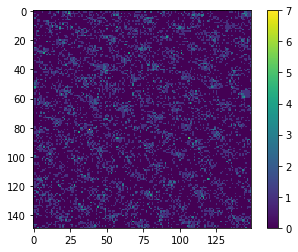

In [55]:
plt.imshow(datacube[:,:,100])
plt.colorbar()
print(np.amax(datacube[1:-1,:]))

In [13]:
# Take 128-by-128 px in k-space, down sampling by a factor of 4, then vectorize into 1024 px
# Ignore the very first row to avoid artifact caused by shutter
path = '/srv/home/chenyu/DEbackup/071519/S7/npy/'
offset = 100  # offset in k space for cropping
for size in range(64,65):
    datacube = np.zeros((149,149,size*size))
    for irow in range(1,150):
        for icol in range(1,150):
            nSample = irow*150+icol+1
            sample = np.load(path+'S7_'+format(nSample,'05')+'.npy')
            sample = sample[offset:offset+size*4,offset:offset+size*4]
            resized = cv2.resize(sample,(size,size),interpolation = cv2.INTER_AREA) # resize into 16x16
            resized = resized / np.sum(resized) * np.sum(sample)
            resized = resized / 224
            datacube[irow-1,icol-1,:] = np.reshape(resized,size*size).astype(int)

    # save as Matlab .mat file
    # Create a dictionary
    adict = {}
    adict['datacube'] = datacube
    sio.savemat('/srv/home/chenyu/DEbackup/071519/S7/datacube_149x149x'+str(size*size)+'_realspace.mat', adict)

In [48]:
# generate input data from the whole datacube
path = '/srv/home/chenyu/DEbackup/2018/110818/S10/npy/'
datacube = np.zeros((149,149,128*128))
for irow in range(1,150):
    for icol in range(1,150):
        nSample = irow*150+icol+1
        sample = np.load(path+'S10_'+format(nSample,'05')+'.npy')
#         sample = sample[100:100+size*4,100:100+size*4] # only take top 64x64px, then downsampling by a factor of 4
        resized = cv2.resize(sample,(128,128),interpolation = cv2.INTER_AREA) # resize into 16x16
        resized = resized / np.sum(resized) * np.sum(sample)
        resized = resized / 224
        datacube[irow-1,icol-1,:] = np.reshape(resized,128*128).astype(int)

# save as Matlab .mat file
# Create a dictionary
adict = {}
adict['datacube'] = datacube
sio.savemat('/srv/home/chenyu/TensorDenoise/Experiment/Experiment_noisy_STO_110818_S10.mat', adict)

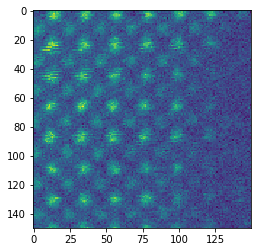

In [47]:
import csv
path = '/srv/home/chenyu/DEbackup/2018/110818/S10/'
file_HAADF = [image for image in os.listdir(path) if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open(path +  file_HAADF) as csvfile:
    file=csv.reader(open(path+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(150,150))
plt.imshow(HAADFarray)

In [15]:
path = '/srv/home/chenyu/DEbackup/071519/S7/npy/'
# generate input data from the whole datacube, in 4-D instead of 3-D
datacube = np.zeros((149,149,128,128))
for irow in range(1,150):
    for icol in range(1,150):
        nSample = irow*150+icol+1
        sample = np.load(path+'S7_'+format(nSample,'05')+'.npy')
#         sample = sample[100:100+size*4,100:100+size*4] # only take top 64x64px, then downsampling by a factor of 4
        resized = cv2.resize(sample,(128,128),interpolation = cv2.INTER_AREA) # resize into 16x16
        resized = resized / np.sum(resized) * np.sum(sample)
        resized = resized / 224
        datacube[irow-1,icol-1,:,:] = resized
#         datacube[irow-1,icol-1,:] = np.reshape(resized,128*128).astype(int)

# save as Matlab .mat file
# Create a dictionary
adict = {}
adict['datacube'] = datacube
sio.savemat('/srv/home/chenyu/DEbackup/071519/S7/datacube_149x149x128x128.mat', adict)

FileNotFoundError: [Errno 2] No such file or directory: '/srv/home/chenyu/DEbackup/071519/S7/npy/S7_00152.npy'

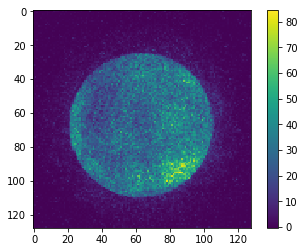

In [24]:
irow = 40
icol = 32
nSample = irow*150+icol+1
sample = np.load(path+'S7_'+format(nSample,'05')+'.npy')
resized = cv2.resize(sample,(128,128),interpolation = cv2.INTER_AREA) # resize into 16x16
resized = resized / np.sum(resized) * np.sum(sample)
resized = resized / 67
plt.imshow(resized)
plt.colorbar()

In [2]:
path = '/srv/home/chenyu/DEbackup/071519/S7/npy/'
iframe = 100
sample = np.load(path+'S7_'+format(iframe,'05')+'.npy') # load raw data in intensity counts

(-0.5, 148.5, 148.5, -0.5)

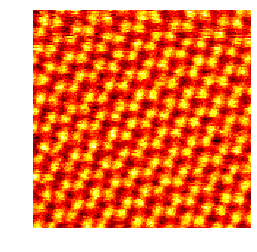

In [16]:
plt.imshow(np.sum(datacube[:,:,10000:10050],axis=2),cmap='hot')
plt.axis('off')
# plt.colorbar()

In [7]:
# Take 64-by-64 px in k-space, down sampling by a factor of 4, then vectorize into 256 px
# Ignore the very first row to avoid artifact caused by shutter
path = '/srv/home/chenyu/DEbackup/2019/081919/S4/npy/'

datacube = np.zeros((150,150,128*128))
for irow in range(25,175):
    for icol in range(25,175):
        nSample = irow*200+icol+1
        sample = np.load(path+'S4_'+format(nSample,'05')+'.npy')
#         sample = sample[100:100+size*4,100:100+size*4] # only take top 64x64px, then downsampling by a factor of 4
        resized = cv2.resize(sample,(128,128),interpolation = cv2.INTER_AREA) # resize into 16x16
        resized = resized / np.sum(resized) * np.sum(sample)
        resized = resized / 224
        datacube[irow-25,icol-25,:] = np.reshape(resized,128*128).astype(int)

In [8]:
# save as Matlab .mat file
# Create a dictionary
adict = {}
adict['datacube'] = datacube
sio.savemat('/srv/home/chenyu/TensorDenoise/Experiment/Experiment_noisy_LiZnSb.mat', adict)